# Classification with FNO
Train an FNO timeseries classifier on handcrafted signal with noise as a proof of concept of using an FNO as a classifier.

In [40]:
import importlib
import model_utils
import data_utils
importlib.reload(model_utils)
importlib.reload(data_utils)
from model_utils import FNOClassifier
from data_utils import SignalDataset, RandomSample, RandomTimeTranslateFill0, RandomTimeTranslateReflect, RandomNoise

import os
import optuna
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import torch
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms

import pytorch_lightning as pl
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
pl.__version__

'2.1.3'

In [41]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available on device {torch.cuda.get_device_name(0)} with device count: {torch.cuda.device_count()}")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available on device NVIDIA GeForce RTX 2080 Ti with device count: 1


## Create a dataloader

In [42]:
# Create train, valid, and test data loaders
total_samples = 300
train_range = [0, int(total_samples*0.7)]
valid_range = [int(total_samples*0.7), int(total_samples*0.9)]
test_range = [int(total_samples*0.9), total_samples]
seq_length = 100
batch_size = 8 # too large of a batchsize crashes the kernel (memory issues due to fft and irfft)
workers = 0
data_augmentation = None
generate_train = False # If True, will generate new signals each batch. Otherwise will generate a full dataset once and batch it.

if data_augmentation == "randomsample":
        n_sample = int(0.8*seq_length)
        seq_length = n_sample
        train_loader = DataLoader(
                SignalDataset(
                        generate=generate_train,
                        idx_range=train_range,
                        seq_length=seq_length,
                        transform=transforms.RandomApply([RandomSample(n_sample=n_sample)], p=1) # Can't be used with other transforms as it changes the shape of the data
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomnoise":
        train_loader = DataLoader(
                SignalDataset(
                        generate=generate_train,
                        idx_range=train_range,
                        seq_length=seq_length,
                        transform=transforms.RandomApply([RandomNoise(mean=0, std=0.1)], p=0.8)
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomtimetranslatefill0":
        train_loader = DataLoader(
                SignalDataset(
                        generate=generate_train,
                        idx_range=train_range,
                        seq_length=seq_length,
                        transform=transforms.RandomApply([RandomTimeTranslateFill0(max_shift=100)], p=0.8)
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomtimetranslatereflect":
        train_loader = DataLoader(
                SignalDataset(
                        generate=generate_train,
                        idx_range=train_range,
                        seq_length=seq_length,
                        transform=transforms.RandomApply([RandomTimeTranslateReflect(max_shift=100)], p=0.8)
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomnoise_randomtimetranslatefill0":
        train_loader = DataLoader(
                SignalDataset(
                        generate=generate_train,
                        idx_range=train_range,
                        seq_length=seq_length,
                        transform=transforms.Compose([
                                transforms.RandomApply([RandomNoise(mean=0, std=0.1)], p=0.5),
                                transforms.RandomApply([RandomTimeTranslateFill0(max_shift=100)], p=0.5),
                        ])
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )   

elif data_augmentation == "randomnoise_randomtimetranslatereflect":
        train_loader = DataLoader(
                SignalDataset(
                        generate=generate_train,
                        idx_range=train_range,
                        seq_length=seq_length,
                        transform=transforms.Compose([
                                transforms.RandomApply([RandomNoise(mean=0, std=0.1)], p=0.5),
                                transforms.RandomApply([RandomTimeTranslateReflect(max_shift=100)], p=0.5),
                        ])
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )    

else:
        train_loader = DataLoader(
                SignalDataset(
                        generate=generate_train,
                        idx_range=train_range,
                        seq_length=seq_length,
                        transform=None
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers, 
        )  

valid_loader = DataLoader(
    SignalDataset(
        generate=False,
        idx_range=valid_range,
        seq_length=seq_length
        
    ),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=workers,
)

test_loader = DataLoader(
    SignalDataset(
        generate=False,
        idx_range=test_range,
        seq_length=seq_length
        
    ),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=workers,
)

# Print the size of a batch and type of data
for x, y in train_loader:
    print("Sample batch of data (batch size, # channels, sequence length): " + str(x.shape))
    print("Sample batch of labels: " + str(y.shape))
    break

# Print number of batches in train and validation set
print(f"Number of batches in train set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(valid_loader)}")

# Print ratios of class 0 and class 1 in the training, test, and valid sets
train_labels = np.zeros(0)
valid_labels = np.zeros(0)
test_labels = np.zeros(0)

for x, y in train_loader:
        train_labels = np.concatenate((train_labels, y.numpy()))
for x, y in valid_loader:
        valid_labels = np.concatenate((valid_labels, y.numpy()))
for x, y in test_loader:
        test_labels = np.concatenate((test_labels, y.numpy()))

print(f"Train set class ratio 0/1: {np.sum(train_labels == 0) / len(train_labels)}")
print(f"Valid set class ratio 0/1: {np.sum(valid_labels == 0) / len(valid_labels)}")
print(f"Test set class ratio 0/1: {np.sum(test_labels == 0) / len(test_labels)}")

Sample batch of data (batch size, # channels, sequence length): torch.Size([8, 1, 100])
Sample batch of labels: torch.Size([8])
Number of batches in train set: 26
Number of batches in validation set: 7
Train set class ratio 0/1: 0.5048076923076923
Valid set class ratio 0/1: 0.5357142857142857
Test set class ratio 0/1: 0.625


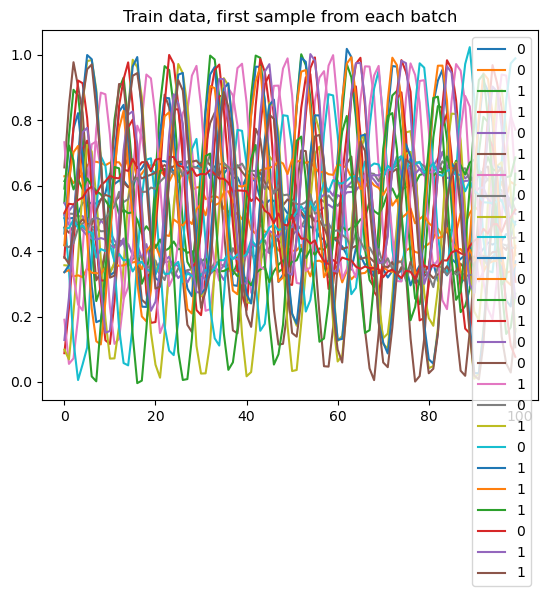

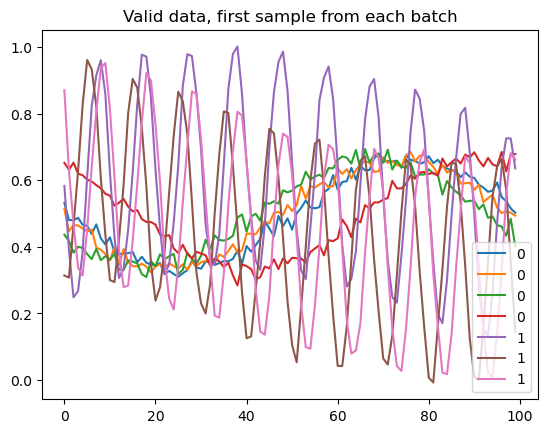

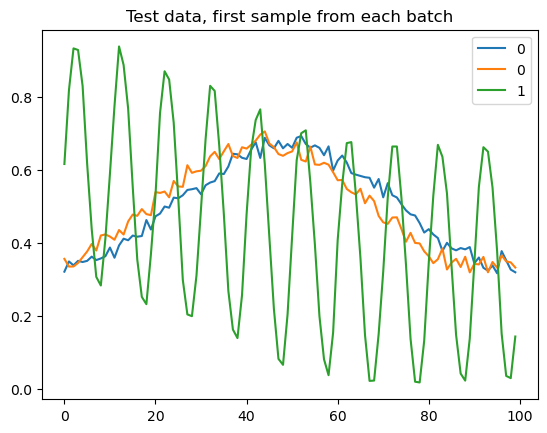

In [43]:
# plot every value in train, test, and valid sets
plt.figure()
plt.title(f"Train data, first sample from each batch")
count = 0
for i, (x, y) in enumerate(train_loader):
    plt.plot(x[0,0,:].numpy(), label=f"{y[0].numpy()}")
    plt.legend()

plt.figure()
plt.title(f"Valid data, first sample from each batch")
for i, (x, y) in enumerate(valid_loader):
    plt.plot(x[0,0,:].numpy(), label=f"{y[0].numpy()}")
    plt.legend()

plt.figure()
plt.title(f"Test data, first sample from each batch")
for i, (x, y) in enumerate(test_loader):
    plt.plot(x[0,0,:].numpy(), label=f"{y[0].numpy()}")
    plt.legend()

## Train and test a model

In [44]:
# Hyperparameters
modes = 6
channels = [256, 128, 64, 32] # Note: if last channel is too big, final fc layer takes over and model collapses
pool_type = "avg" 
pooling = seq_length # Remember to change this if using RandomSample augmentation
proj_dim = 32 # Dimension to project to initially
p_dropout = 0.5
add_noise = False

# Optimizers and learning rate schedulers
# lr schedule options are reducelronplateau, steplr, exponentiallr, cosineannealinglr, and cosineannealingwarmrestarts
# optimizer options are sgd or adam
optimizer = "adam"
momentum = 0 # Only used for SGD optimizer
scheduler = "reducelronplateau"
lr = 1e-2

# Initialize classifier
classifier = FNOClassifier(
                modes=modes, 
                lr=lr, 
                channels=channels, 
                pooling=pooling, 
                optimizer=optimizer, 
                scheduler=scheduler, 
                momentum=momentum, 
                pool_type=pool_type, 
                seq_length=seq_length,
                proj_dim=proj_dim,
                p_dropout=p_dropout, 
                add_noise=add_noise
)

# Print the model
print(classifier)

FNOClassifier(
  (loss): BCELoss()
  (project): Sequential(
    (0): Linear(in_features=100, out_features=3200, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (fno_layer_0): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([32, 256, 4]), rank=None)
      )
    )
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fno_layer_1): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([256, 128, 4]), rank=None)
      )
    )
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fno_layer_2): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([128, 64, 4]), rank=None)
      )
    )
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fno_layer_3): Sequential(
    (0): S

In [45]:
# Create a tensorboard logger
experiment_name = "signal_dataset_second_pass"
save_directory = "../logs/"

# Check if save_dir/experiment_name exists, if not create it
if not os.path.exists(save_directory + experiment_name):
    os.makedirs(save_directory + experiment_name)

logger = TensorBoardLogger(save_dir=save_directory, name=experiment_name, version=datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
logger.log_hyperparams({
    "modes": modes, 
    "lr": lr, 
    "proj_dim": proj_dim,
    "channels": channels,
    "pool_type": pool_type, 
    "pooling": pooling, 
    "lr_scheduler": scheduler, 
    "batchsize": batch_size, 
    "optimizer": optimizer, 
    "momentum": momentum,
    "p_dropout": p_dropout,
    "add_noise": add_noise,
    "data_augmentation": data_augmentation,
    "neuralop_or_mine": "neuralop_package"
})
print("Tensorboard logs will be saved to: " + logger.log_dir)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, mode="min"),
    LearningRateMonitor(logging_interval="step"),
]

# Train the model
trainer = Trainer(max_epochs=100,
                  logger=logger,
                  callbacks=callbacks,
                  accelerator="auto"
)

trainer.fit(model=classifier, 
            train_dataloaders=train_loader,
            val_dataloaders=valid_loader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | In sizes      | Out sizes    
-------------------------------------------------------------------------------
0 | loss            | BCELoss    | 0      | ?             | ?            
1 | project         | Sequential | 323 K  | [1, 1, 100]   | [1, 1, 3200] 
2 | fno_layer_0     | Sequential | 66.3 K | [1, 32, 100]  | [1, 256, 100]
3 | fno_layer_1     | Sequential | 262 K  | [1, 256, 100] | [1, 128, 100]
4 | fno_layer_2     | Sequential | 65.7 K | [1, 128, 100] | [1, 64, 100] 
5 | fno_layer_3     | Sequential | 16.5 K | [1, 64, 100]  | [1, 32, 100] 
6 | dropout         | Dropout    | 0      | [1, 32]       | [1, 32]      
7 | fc_post_dropout | Linear     | 33     | [1, 32]       | [1, 1]       
8 | pool            | AvgPool1d  | 0      | [1, 32, 100]  |

Tensorboard logs will be saved to: ../logs/signal_dataset_second_pass/2024_04_18-01_55_14


SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [16]:
# Test the model
trainer.test(dataloaders=test_loader)

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/fno/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at ../logs/signal_dataset_second_pass/2024_04_16-23_59_30/checkpoints/epoch=49-step=1050.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/signal_dataset_second_pass/2024_04_16-23_59_30/checkpoints/epoch=49-step=1050.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   7.257874017341237e-07   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 7.257874017341237e-07, 'test_acc': 1.0}]

Accuracy: 1.0


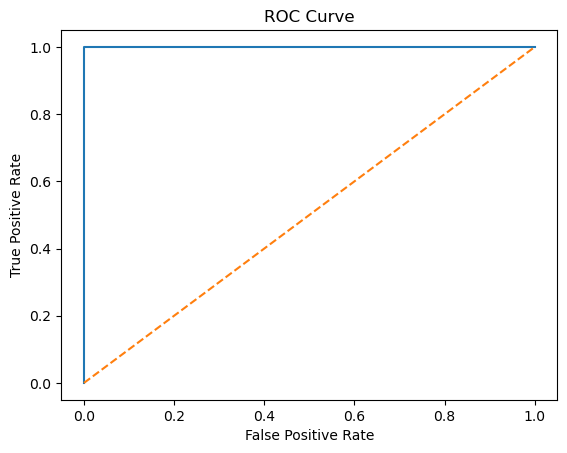

In [17]:
classifier.eval()

# Get the true labels and predicted probabilities
y_true = np.zeros(0)
y_pred_probs = np.zeros(0)

for x, y in test_loader:
    y_true = np.concatenate((y_true, y.flatten().numpy()))
    y_pred = classifier.forward(x).detach().numpy()
    y_pred_probs = np.concatenate((y_pred_probs, y_pred[:]))

# Calculate accuracy
binary_y_pred = np.where(y_pred_probs > 0.5, 1, 0)
accuracy = np.sum(binary_y_pred == y_true) / len(y_true)
print(f"Accuracy: {accuracy}")

# Calculate the FPR and TPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()